In [1]:
%load_ext autoreload
%autoreload 2

from dataloader import SignalDataloader
from pathlib import Path
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import lightning.pytorch as pl
import yaml
from tqdm import tqdm
from ml4gw.transforms import SpectralDensity, Whiten

device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

/home/eric.moreno/gwak2/gwak/data/prior.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
data_dir = "/home/katya.govorkova/gwak2/gwak/output/O4_MDC_background/test/"
sample_rate = 2048
kernel_length = 0.5
psd_length = 64
fduration = 1
fftlength = 2
batch_size = 512
batches_per_epoch = 20
num_workers = 2
data_saving_file = None
duration = fduration + kernel_length

from gwak.data.prior import SineGaussianBBC, LAL_BBHPrior, GaussianBBC, CuspBBC, KinkBBC, KinkkinkBBC, WhiteNoiseBurstBBC
from ml4gw.waveforms import SineGaussian, IMRPhenomPv2, Gaussian, GenerateString, WhiteNoiseBurst

signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]
priors = [
    SineGaussianBBC(),
    LAL_BBHPrior(),
    GaussianBBC(),
    CuspBBC(),
    KinkBBC(),
    KinkkinkBBC(),
    WhiteNoiseBurstBBC(),
    None
]
waveforms = [
    SineGaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    IMRPhenomPv2(),
    Gaussian(
        sample_rate=sample_rate,
        duration=duration
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    GenerateString(
        sample_rate=sample_rate
    ),
    WhiteNoiseBurst(
        sample_rate=sample_rate,
        duration=duration
    ),
    None
]
extra_kwargs = [
    None,
    {"ringdown_duration":0.9},
    None,
    None,
    None,
    None,
    None,
    None
]

In [3]:
loader = SignalDataloader(signal_classes,
    priors,
    waveforms,
    extra_kwargs,
    data_dir=data_dir,
    sample_rate=sample_rate,
    kernel_length=kernel_length,
    psd_length=psd_length,
    fduration=fduration,
    fftlength=fftlength,
    batch_size=batch_size,
    batches_per_epoch=batches_per_epoch,
    num_workers=num_workers,
    data_saving_file=data_saving_file
)
test_loader = loader.train_dataloader()

None True
{'ringdown_duration': 0.9} False
None True
None True
None True
None True
None True
None True


In [4]:
for batch in test_loader:
    print(batch)
    [batch] = batch
    print(batch)
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    x = loader.multiInject(waveforms, batch)
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)])
    break

ValueError: Caught ValueError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/eric.moreno/miniconda3/envs/gwak3/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "/home/eric.moreno/miniconda3/envs/gwak3/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 33, in fetch
    data.append(next(self.dataset_iter))
                ^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eric.moreno/miniconda3/envs/gwak3/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py", line 176, in __iter__
    yield self.sample_batch()
          ^^^^^^^^^^^^^^^^^^^
  File "/home/eric.moreno/miniconda3/envs/gwak3/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py", line 123, in sample_batch
    fnames = self.sample_fnames(size)
             ^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/eric.moreno/miniconda3/envs/gwak3/lib/python3.11/site-packages/ml4gw/dataloading/hdf5_dataset.py", line 102, in sample_fnames
    return np.random.choice(
           ^^^^^^^^^^^^^^^^^
  File "numpy/random/mtrand.pyx", line 951, in numpy.random.mtrand.RandomState.choice
ValueError: 'a' cannot be empty unless no samples are taken


In [ ]:
from sklearn.metrics import roc_curve, auc

combined_model_path = "/home/eric.moreno/gwak2/gwak/output/combination/model_JIT.pt" # Replace with your actual model file path
combined_model = torch.jit.load(combined_model_path)
combined_model = combined_model.to(device)
combined_model.eval()

# Containers to store anomaly scores and binary labels
all_scores = []
all_binary_labels = []

# Iterate over the test data loader
for batch in tqdm(test_loader):
    [batch] = batch
    # Generate the corresponding waveforms
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)
    
    # Process the waveforms into the required input format
    x = loader.multiInject(waveforms, batch)
    
    # Reconstruct the ground truth multi-class labels
    labels = torch.cat([(i+1)*torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]).to(device)
    
    with torch.no_grad():
        # The combined model directly outputs the anomaly score
        scores = combined_model(x).squeeze()  # (batch_size,)
        scores = scores.cpu().numpy()
        # Invert the scores so that higher values correspond to more anomalous behavior
        scores = -scores
    
    # Convert the multi-class labels to binary labels:
    # Treat "Background" (assumed to be label 8) as 0 (normal) and all other classes as 1 (anomaly)
    binary_labels = (labels != 8).cpu().numpy()
    
    all_scores.append(scores)
    all_binary_labels.append(binary_labels)

# Concatenate scores and labels across batches
all_scores = np.concatenate(all_scores)
all_binary_labels = np.concatenate(all_binary_labels)

# Compute the ROC curve and AUC using scikit-learn
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [12:45<00:00, 76.57s/it]


ModuleNotFoundError: No module named 'sklearn'

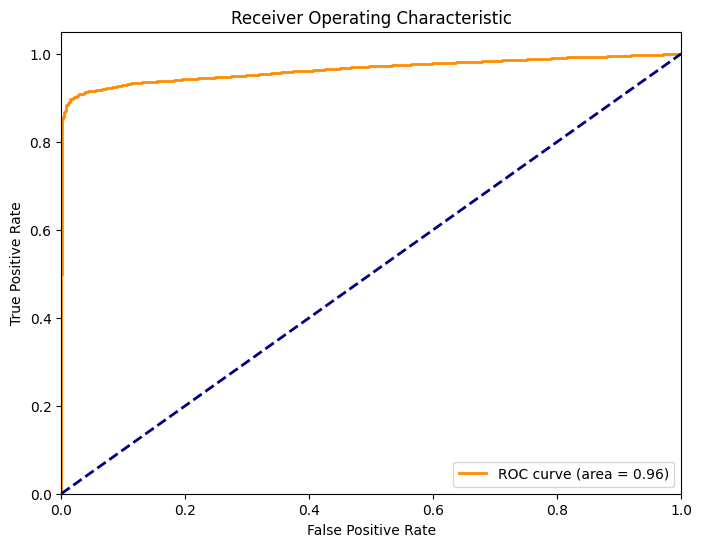

In [22]:
# Compute the ROC curve and AUC using scikit-learn
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(all_binary_labels, all_scores)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic")
plt.legend(loc="lower right")
plt.show()

In [44]:
# Load the combined anomaly detection model (update the path accordingly)
combined_model = torch.jit.load(combined_model_path)
combined_model = combined_model.to(device)  # ensure model is on the same device
combined_model.eval()

# Containers to store anomaly scores and multi-class labels (as numeric values)
all_scores = []
all_labels = []

# Iterate over the test data loader
for batch in tqdm(test_loader):
    [batch] = batch
    # Generate the corresponding waveforms
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    print(params)
    batch = batch.to(device)
    
    # Process the waveforms into the required input format
    x = loader.multiInject(waveforms, batch)
    
    # Construct the ground truth multi-class labels.
    # Here each class gets a label from 1 to num_classes; "Background" is assumed to be the last class (label = 8).
    labels = torch.cat([(i+1) * torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]).to(device)
    
    with torch.no_grad():
        # The combined model directly outputs the anomaly score for each input.
        scores = combined_model(x).squeeze()  # shape: (batch_size,)
        scores = scores.cpu().numpy()
        # Invert the scores so that higher values correspond to more anomalous behavior.
        scores = -scores
    
    all_scores.append(scores)
    all_labels.append(labels.cpu().numpy())

# Concatenate results across batches
all_scores = np.concatenate(all_scores)
all_labels = np.concatenate(all_labels)

# The list of signal class names, with the last one being "Background".
signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background"
]

# Compute and plot ROC curves for each anomaly class (all but "Background").
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.ylog()
plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.show()

  0%|          | 0/20 [00:00<?, ?it/s]

[OrderedDict([('hrss', tensor([5.3755e-21, 2.6577e-20, 4.6614e-20, 1.0448e-20, 4.3742e-20, 2.3871e-20,
        1.3654e-20, 3.3405e-20, 4.0370e-20, 1.7358e-20, 1.1632e-20, 4.2686e-20,
        3.2162e-20, 1.0618e-20, 1.2935e-20, 4.6777e-20, 3.4961e-20, 2.6375e-20,
        2.0792e-20, 4.6802e-20, 7.7524e-21, 3.3727e-20, 3.4795e-20, 6.8978e-21,
        2.2202e-20, 1.3527e-20, 2.4811e-20, 1.4208e-20, 4.6603e-20, 4.7308e-20,
        3.8108e-20, 1.5171e-20, 1.6044e-20, 2.9728e-21, 1.6709e-20, 6.3260e-21,
        7.1890e-21, 4.7823e-20, 1.9905e-20, 2.9475e-20, 4.8490e-20, 1.8717e-20,
        7.6597e-21, 4.7509e-20, 3.2633e-20, 2.0095e-20, 1.4982e-20, 3.4132e-20,
        2.9052e-20, 2.1459e-20, 4.1696e-20, 3.7038e-20, 4.1849e-20, 1.0793e-20,
        1.9979e-21, 2.9107e-20, 4.4271e-20, 1.0584e-20, 2.3451e-20, 1.4919e-20,
        3.9932e-20, 7.8343e-21, 3.1398e-20, 3.2136e-20])), ('quality', tensor([ 32.2223, 520.6149, 359.5212, 344.3240, 171.1507, 572.5117, 105.8219,
        457.9870, 194.1167, 

  0%|          | 0/20 [01:38<?, ?it/s]


RuntimeError: forward() Expected a value of type 'Tensor' for argument 'x' but instead found type 'tuple'.
Position: 1
Value: (tensor([[[-1.5125e-02, -7.0581e-02, -6.9940e-02,  ..., -6.6587e-02,
          -7.0667e-02,  9.0365e-03],
         [-4.1541e-03,  6.8999e-03, -1.7420e-02,  ...,  2.7206e-02,
           1.4861e-03,  8.6599e-02]],

        [[ 4.6454e-02, -5.3838e-02,  8.2531e-02,  ..., -1.0128e-02,
          -5.9240e-03,  2.6531e-02],
         [ 5.2810e-02, -6.0880e-02,  1.8389e-02,  ..., -6.3485e-02,
           4.9270e-02, -3.9765e-02]],

        [[-8.3913e-03,  1.0128e-02,  7.1165e-03,  ..., -5.0163e-02,
           1.8453e-03,  5.0982e-02],
         [-3.0563e-02,  3.4835e-03,  2.2872e-02,  ...,  1.8772e-02,
           1.4757e-02, -3.5658e-02]],

        ...,

        [[ 5.7494e-01,  3.0706e-01,  1.9890e+00,  ..., -5.0080e-01,
           8.7748e-01,  5.4700e-01],
         [-4.9156e-01, -1.1220e+00, -8.9827e-01,  ..., -1.1343e+00,
          -7.2535e-01,  9.2301e-01]],

        [[ 1.2883e+00, -8.4237e-01, -3.1845e-01,  ..., -3.1182e-01,
          -1.4725e+00, -1.8943e+00],
         [-7.0163e-01, -1.1009e+00, -7.1195e-01,  ..., -1.7131e+00,
           4.7767e-01, -1.5529e-01]],

        [[-1.5966e+00,  6.4242e-01, -1.7627e+00,  ...,  1.0354e+00,
           1.2185e-02, -2.0132e-01],
         [-8.4671e-01, -1.4357e+00,  2.2298e-01,  ..., -1.1946e+00,
           5.7516e-01, -9.6558e-01]]], device='cuda:0'), tensor([1.0795e+01, 2.1831e+00, 2.4773e+01, 1.0994e+01, 2.7745e+00, 6.2785e+00,
        5.2033e+00, 1.2761e+01, 4.5732e+00, 2.6125e+00, 2.0152e+00, 6.9489e+00,
        8.5983e+00, 9.7194e+00, 1.0577e+01, 1.0158e+01, 8.9393e+00, 8.7176e+00,
        9.8879e+00, 3.7257e+00, 7.8181e+00, 2.2944e+00, 7.5089e+00, 8.0771e+00,
        3.1670e+00, 3.1713e+00, 8.3337e+00, 4.2130e+00, 2.3811e+01, 1.6448e+01,
        1.0831e+01, 6.0194e+00, 1.2736e+00, 2.9332e+00, 1.9314e+00, 7.8069e+00,
        1.4162e+01, 4.3550e+00, 2.4004e+00, 8.0939e+00, 3.1428e+01, 5.9906e+00,
        1.5378e+00, 1.6053e+01, 5.0423e+01, 2.0809e+00, 5.9987e+00, 5.1488e+00,
        1.5117e+01, 5.4356e+00, 1.6646e+00, 1.5365e+01, 3.0908e+00, 1.1482e+00,
        4.9812e+00, 2.2307e+01, 8.3031e+00, 4.1511e+00, 3.2331e+00, 3.6122e+00,
        6.3125e+00, 1.3780e+00, 2.8413e+00, 8.3148e+00, 6.4702e+00, 1.8914e+00,
        2.1507e+00, 7.8950e-01, 2.5005e+00, 1.3371e+00, 1.4824e+01, 3.3002e+00,
        8.7495e+00, 3.1502e+00, 1.6826e+00, 1.7280e+00, 6.7593e-01, 3.3080e+00,
        1.6653e+00, 3.4808e+00, 1.2556e+00, 1.2895e+00, 2.3128e+00, 1.8118e+00,
        1.4260e+01, 3.4849e+00, 2.5625e+00, 7.0720e+00, 7.9277e-01, 1.5430e+00,
        4.9745e+00, 3.6404e+00, 7.6840e-01, 1.1900e+00, 7.1772e-01, 3.1641e+00,
        1.3611e+00, 1.3782e+01, 1.2898e+00, 8.3328e+01, 5.9298e+00, 3.9428e+00,
        5.6965e+00, 1.4561e+01, 1.8770e+00, 1.8731e+00, 1.7857e+00, 1.9934e+00,
        1.4558e+01, 5.1179e+00, 1.1056e+00, 9.5573e+00, 1.0018e+00, 7.5949e+00,
        1.7686e+00, 3.5955e+00, 3.7548e-01, 2.8962e+00, 1.5693e+00, 1.2312e+01,
        6.7196e-01, 3.7158e+00, 8.6646e+00, 1.2729e+00, 1.2668e+00, 1.8137e+00,
        7.0424e+00, 3.8483e+00, 1.3059e+04, 3.2724e+04, 2.3772e+04, 1.3751e+04,
        1.5689e+03, 8.1510e+03, 2.8568e+02, 4.8261e+04, 1.5842e+03, 1.4080e+04,
        1.5084e+05, 5.8907e+04, 4.6486e+03, 2.4878e+05, 1.1979e+00, 9.1673e+03,
        1.1448e+04, 2.7971e+04, 1.7281e+04, 1.5865e+05, 5.4300e+04, 5.6014e+03,
        1.1034e+05, 1.9741e+04, 3.6917e+02, 3.3467e+04, 5.2417e+02, 1.4244e+02,
        9.5783e+01, 3.8423e+04, 2.4017e+05, 7.4758e+04, 5.9918e+02, 1.5577e+04,
        1.5799e+03, 4.1791e+02, 1.9169e+04, 6.9924e+03, 2.7098e+04, 7.1156e+03,
        8.6228e+03, 3.4313e+03, 1.3312e+05, 6.6247e+04, 2.0723e+04, 2.0621e+03,
        1.4555e+04, 5.5595e+02, 5.7817e+02, 9.8239e+01, 7.0493e+04, 2.3264e+03,
        1.5026e+04, 2.0587e+05, 2.3898e+04, 9.0896e+03, 2.1719e+03, 1.5793e+03,
        3.0694e+03, 1.0132e+04, 6.7915e+04, 9.0764e+04, 1.2223e+04, 4.8704e+04,
        4.9098e+00, 2.2190e+00, 3.1648e+00, 5.1201e-01, 1.9783e+00, 1.7624e+00,
        1.3600e+01, 2.6049e+00, 2.9299e+00, 1.2543e+00, 6.7267e+00, 2.2875e+00,
        3.3597e+00, 1.8413e+00, 8.1013e+00, 6.3192e+00, 5.9785e+00, 3.6719e+00,
        2.9206e+00, 2.0783e+00, 2.9471e+00, 1.1272e+00, 9.0142e-01, 2.8437e+00,
        9.4030e+00, 8.0006e-01, 1.7608e+00, 6.9705e+00, 1.2437e+00, 1.1749e+01,
        1.0884e+00, 3.9180e+00, 5.8623e+00, 2.6409e+00, 1.1108e+00, 2.6040e+00,
        2.9577e+00, 4.8239e-01, 2.5270e+00, 3.1240e+00, 5.2208e+00, 1.9072e+00,
        1.9617e+00, 6.1372e+00, 4.7931e+00, 6.9995e-01, 1.0965e+00, 6.7178e-01,
        2.7637e+00, 1.3388e+00, 2.2687e+00, 2.5017e+00, 3.1060e+00, 1.2560e+00,
        2.7967e+00, 1.0875e+00, 1.5356e+01, 1.1800e+00, 3.0310e+00, 2.3192e+00,
        7.3794e-01, 1.1915e+00, 8.1744e+00, 3.3149e+00, 1.2096e+00, 3.9539e+00,
        5.2080e-01, 1.5038e+00, 2.7643e+00, 1.0119e+00, 4.0666e+00, 4.8064e-01,
        1.0071e+00, 2.4345e+00, 3.5257e+00, 6.3632e-01, 3.0908e+00, 2.0876e+00,
        1.2002e+00, 1.2979e+00, 2.3431e+00, 2.1339e+00, 3.4987e+00, 2.9723e+00,
        2.2174e+00, 5.9069e+00, 1.7048e+00, 4.5308e+00, 1.8175e+00, 3.0775e+00,
        6.5754e+00, 5.1279e-01, 1.5832e+00, 7.1619e-01, 1.9287e+00, 2.0231e+00,
        4.6020e+00, 3.3759e+00, 1.2532e+00, 1.1924e+01, 1.8350e+00, 1.4517e+00,
        1.0326e+00, 2.8687e+00, 1.3826e+00, 4.3072e+00, 5.2888e-01, 8.8216e-01,
        8.8179e-01, 3.9693e+00, 1.5397e+00, 2.7966e+00, 1.5415e+00, 8.2618e+00,
        6.8913e+00, 7.7083e+00, 2.7451e+00, 4.4608e+00, 6.6745e-01, 2.1051e+00,
        2.5922e+00, 1.0714e+01, 1.6369e+01, 6.4323e+00, 2.0156e+01, 3.0175e+00,
        1.4444e+00, 2.0929e+00, 3.8105e+00, 1.7981e+00, 1.1068e+00, 8.6013e+00,
        4.0757e+00, 1.8850e+00, 6.4930e+00, 9.8571e-01, 2.5077e+00, 1.2415e+00,
        2.3337e+00, 2.2605e+00, 1.9608e+00, 5.5925e+00, 2.3960e+00, 2.4626e+00,
        2.6050e+00, 1.3986e+00, 1.4350e+00, 2.1983e+00, 2.2386e+00, 1.2218e+01,
        2.3427e+00, 4.2981e-01, 1.5446e+00, 1.1226e+00, 2.9644e+00, 3.2426e+00,
        1.6818e+00, 1.6841e+00, 5.7665e+00, 1.2704e+00, 1.7280e+00, 3.6878e+00,
        2.0062e+00, 1.5555e+00, 4.2521e+00, 2.1847e+00, 1.6204e+00, 1.8215e+00,
        6.0160e+00, 1.1955e+01, 3.0347e+00, 1.4111e+00, 1.2767e+00, 1.6363e+00,
        3.9910e+00, 2.2537e+00, 6.4615e-01, 7.3421e+00, 3.6518e+00, 2.4322e+00,
        5.2161e+00, 7.0136e-01, 1.0762e+01, 7.3651e+00, 2.0868e+00, 5.8912e+00,
        4.0618e+00, 1.0473e+01, 6.6236e+00, 6.6279e-01, 4.8868e-01, 1.9488e+01,
        1.7778e+26, 1.4383e+26, 6.5886e+25, 1.3459e+26, 1.3060e+26, 3.2070e+25,
        2.6280e+25, 1.0151e+26, 1.5045e+25, 2.9462e+25, 5.6548e+25, 4.4550e+25,
        9.6636e+25, 4.6919e+25, 1.5162e+25, 6.0852e+25, 1.1138e+26, 3.3615e+25,
        5.9561e+25, 2.5556e+25, 1.0407e+26, 1.8358e+26, 3.8383e+25, 5.4759e+24,
        1.9819e+25, 3.0172e+25, 1.1614e+26, 4.4695e+24, 4.7800e+25, 4.9960e+25,
        3.4087e+25, 1.2590e+26, 1.4311e+26, 7.5581e+25, 2.4205e+26, 8.2978e+25,
        1.8402e+25, 1.2563e+26, 5.0521e+25, 7.8216e+25, 1.3192e+26, 1.0820e+26,
        3.6671e+25, 6.9872e+25, 1.2186e+26, 2.9505e+25, 8.1987e+25, 6.4002e+25,
        2.4582e+26, 7.1736e+25, 1.8691e+26, 2.9644e+25, 5.2121e+24, 8.2327e+25,
        3.5824e+25, 4.4440e+25, 8.4904e+25, 3.7860e+25, 3.5027e+26, 4.6061e+25,
        8.8454e+25, 5.1776e+25, 9.4042e+25, 6.4063e+24, 2.0763e+00, 1.6739e+00,
        4.7825e+00, 3.5250e+00, 2.1079e+01, 4.2682e+00, 2.3521e+00, 8.2850e-01,
        1.4319e+00, 1.2009e+00, 1.0836e+00, 6.1017e+00, 5.5594e+00, 2.4564e+00,
        3.5720e+00, 2.7718e+00, 4.1656e+00, 2.5967e+00, 5.8489e+00, 1.0334e+00,
        1.0941e+00, 1.4203e+01, 4.0011e-01, 8.4832e+00, 1.7236e+00, 3.2178e+00,
        2.2715e+00, 6.5239e-01, 2.7177e+00, 5.9655e-01, 2.9001e+00, 3.6984e+00,
        2.8825e+00, 1.8720e+00, 1.5119e+01, 5.1582e+00, 9.2664e-01, 6.0335e-01,
        7.3571e-01, 5.8795e+00, 2.0846e+00, 7.2418e-01, 2.7992e+00, 1.3650e+00,
        1.1457e+01, 8.3087e+00, 1.0081e+00, 1.2124e+00, 2.2228e+00, 2.1771e+00,
        8.9049e-01, 1.6176e+00, 1.7942e+00, 3.5023e+00, 1.5295e+00, 2.8132e+00,
        5.0508e+00, 4.9371e+00, 3.0186e+00, 1.4514e+00, 8.6710e-01, 2.5250e+01,
        1.7135e+00, 2.6480e+00], device='cuda:0'))
Declaration: forward(__torch__.CombinedModel self, Tensor x) -> Tensor
Cast error details: Unable to cast (tensor([[[-1.5125e-02, -7.0581e-02, -6.9940e-02,  ..., -6.6587e-02,
          -7.0667e-02,  9.0365e-03],
         [-4.1541e-03,  6.8999e-03, -1.7420e-02,  ...,  2.7206e-02,
           1.4861e-03,  8.6599e-02]],

        [[ 4.6454e-02, -5.3838e-02,  8.2531e-02,  ..., -1.0128e-02,
          -5.9240e-03,  2.6531e-02],
         [ 5.2810e-02, -6.0880e-02,  1.8389e-02,  ..., -6.3485e-02,
           4.9270e-02, -3.9765e-02]],

        [[-8.3913e-03,  1.0128e-02,  7.1165e-03,  ..., -5.0163e-02,
           1.8453e-03,  5.0982e-02],
         [-3.0563e-02,  3.4835e-03,  2.2872e-02,  ...,  1.8772e-02,
           1.4757e-02, -3.5658e-02]],

        ...,

        [[ 5.7494e-01,  3.0706e-01,  1.9890e+00,  ..., -5.0080e-01,
           8.7748e-01,  5.4700e-01],
         [-4.9156e-01, -1.1220e+00, -8.9827e-01,  ..., -1.1343e+00,
          -7.2535e-01,  9.2301e-01]],

        [[ 1.2883e+00, -8.4237e-01, -3.1845e-01,  ..., -3.1182e-01,
          -1.4725e+00, -1.8943e+00],
         [-7.0163e-01, -1.1009e+00, -7.1195e-01,  ..., -1.7131e+00,
           4.7767e-01, -1.5529e-01]],

        [[-1.5966e+00,  6.4242e-01, -1.7627e+00,  ...,  1.0354e+00,
           1.2185e-02, -2.0132e-01],
         [-8.4671e-01, -1.4357e+00,  2.2298e-01,  ..., -1.1946e+00,
           5.7516e-01, -9.6558e-01]]], device='cuda:0'), tensor([1.0795e+01, 2.1831e+00, 2.4773e+01, 1.0994e+01, 2.7745e+00, 6.2785e+00,
        5.2033e+00, 1.2761e+01, 4.5732e+00, 2.6125e+00, 2.0152e+00, 6.9489e+00,
        8.5983e+00, 9.7194e+00, 1.0577e+01, 1.0158e+01, 8.9393e+00, 8.7176e+00,
        9.8879e+00, 3.7257e+00, 7.8181e+00, 2.2944e+00, 7.5089e+00, 8.0771e+00,
        3.1670e+00, 3.1713e+00, 8.3337e+00, 4.2130e+00, 2.3811e+01, 1.6448e+01,
        1.0831e+01, 6.0194e+00, 1.2736e+00, 2.9332e+00, 1.9314e+00, 7.8069e+00,
        1.4162e+01, 4.3550e+00, 2.4004e+00, 8.0939e+00, 3.1428e+01, 5.9906e+00,
        1.5378e+00, 1.6053e+01, 5.0423e+01, 2.0809e+00, 5.9987e+00, 5.1488e+00,
        1.5117e+01, 5.4356e+00, 1.6646e+00, 1.5365e+01, 3.0908e+00, 1.1482e+00,
        4.9812e+00, 2.2307e+01, 8.3031e+00, 4.1511e+00, 3.2331e+00, 3.6122e+00,
        6.3125e+00, 1.3780e+00, 2.8413e+00, 8.3148e+00, 6.4702e+00, 1.8914e+00,
        2.1507e+00, 7.8950e-01, 2.5005e+00, 1.3371e+00, 1.4824e+01, 3.3002e+00,
        8.7495e+00, 3.1502e+00, 1.6826e+00, 1.7280e+00, 6.7593e-01, 3.3080e+00,
        1.6653e+00, 3.4808e+00, 1.2556e+00, 1.2895e+00, 2.3128e+00, 1.8118e+00,
        1.4260e+01, 3.4849e+00, 2.5625e+00, 7.0720e+00, 7.9277e-01, 1.5430e+00,
        4.9745e+00, 3.6404e+00, 7.6840e-01, 1.1900e+00, 7.1772e-01, 3.1641e+00,
        1.3611e+00, 1.3782e+01, 1.2898e+00, 8.3328e+01, 5.9298e+00, 3.9428e+00,
        5.6965e+00, 1.4561e+01, 1.8770e+00, 1.8731e+00, 1.7857e+00, 1.9934e+00,
        1.4558e+01, 5.1179e+00, 1.1056e+00, 9.5573e+00, 1.0018e+00, 7.5949e+00,
        1.7686e+00, 3.5955e+00, 3.7548e-01, 2.8962e+00, 1.5693e+00, 1.2312e+01,
        6.7196e-01, 3.7158e+00, 8.6646e+00, 1.2729e+00, 1.2668e+00, 1.8137e+00,
        7.0424e+00, 3.8483e+00, 1.3059e+04, 3.2724e+04, 2.3772e+04, 1.3751e+04,
        1.5689e+03, 8.1510e+03, 2.8568e+02, 4.8261e+04, 1.5842e+03, 1.4080e+04,
        1.5084e+05, 5.8907e+04, 4.6486e+03, 2.4878e+05, 1.1979e+00, 9.1673e+03,
        1.1448e+04, 2.7971e+04, 1.7281e+04, 1.5865e+05, 5.4300e+04, 5.6014e+03,
        1.1034e+05, 1.9741e+04, 3.6917e+02, 3.3467e+04, 5.2417e+02, 1.4244e+02,
        9.5783e+01, 3.8423e+04, 2.4017e+05, 7.4758e+04, 5.9918e+02, 1.5577e+04,
        1.5799e+03, 4.1791e+02, 1.9169e+04, 6.9924e+03, 2.7098e+04, 7.1156e+03,
        8.6228e+03, 3.4313e+03, 1.3312e+05, 6.6247e+04, 2.0723e+04, 2.0621e+03,
        1.4555e+04, 5.5595e+02, 5.7817e+02, 9.8239e+01, 7.0493e+04, 2.3264e+03,
        1.5026e+04, 2.0587e+05, 2.3898e+04, 9.0896e+03, 2.1719e+03, 1.5793e+03,
        3.0694e+03, 1.0132e+04, 6.7915e+04, 9.0764e+04, 1.2223e+04, 4.8704e+04,
        4.9098e+00, 2.2190e+00, 3.1648e+00, 5.1201e-01, 1.9783e+00, 1.7624e+00,
        1.3600e+01, 2.6049e+00, 2.9299e+00, 1.2543e+00, 6.7267e+00, 2.2875e+00,
        3.3597e+00, 1.8413e+00, 8.1013e+00, 6.3192e+00, 5.9785e+00, 3.6719e+00,
        2.9206e+00, 2.0783e+00, 2.9471e+00, 1.1272e+00, 9.0142e-01, 2.8437e+00,
        9.4030e+00, 8.0006e-01, 1.7608e+00, 6.9705e+00, 1.2437e+00, 1.1749e+01,
        1.0884e+00, 3.9180e+00, 5.8623e+00, 2.6409e+00, 1.1108e+00, 2.6040e+00,
        2.9577e+00, 4.8239e-01, 2.5270e+00, 3.1240e+00, 5.2208e+00, 1.9072e+00,
        1.9617e+00, 6.1372e+00, 4.7931e+00, 6.9995e-01, 1.0965e+00, 6.7178e-01,
        2.7637e+00, 1.3388e+00, 2.2687e+00, 2.5017e+00, 3.1060e+00, 1.2560e+00,
        2.7967e+00, 1.0875e+00, 1.5356e+01, 1.1800e+00, 3.0310e+00, 2.3192e+00,
        7.3794e-01, 1.1915e+00, 8.1744e+00, 3.3149e+00, 1.2096e+00, 3.9539e+00,
        5.2080e-01, 1.5038e+00, 2.7643e+00, 1.0119e+00, 4.0666e+00, 4.8064e-01,
        1.0071e+00, 2.4345e+00, 3.5257e+00, 6.3632e-01, 3.0908e+00, 2.0876e+00,
        1.2002e+00, 1.2979e+00, 2.3431e+00, 2.1339e+00, 3.4987e+00, 2.9723e+00,
        2.2174e+00, 5.9069e+00, 1.7048e+00, 4.5308e+00, 1.8175e+00, 3.0775e+00,
        6.5754e+00, 5.1279e-01, 1.5832e+00, 7.1619e-01, 1.9287e+00, 2.0231e+00,
        4.6020e+00, 3.3759e+00, 1.2532e+00, 1.1924e+01, 1.8350e+00, 1.4517e+00,
        1.0326e+00, 2.8687e+00, 1.3826e+00, 4.3072e+00, 5.2888e-01, 8.8216e-01,
        8.8179e-01, 3.9693e+00, 1.5397e+00, 2.7966e+00, 1.5415e+00, 8.2618e+00,
        6.8913e+00, 7.7083e+00, 2.7451e+00, 4.4608e+00, 6.6745e-01, 2.1051e+00,
        2.5922e+00, 1.0714e+01, 1.6369e+01, 6.4323e+00, 2.0156e+01, 3.0175e+00,
        1.4444e+00, 2.0929e+00, 3.8105e+00, 1.7981e+00, 1.1068e+00, 8.6013e+00,
        4.0757e+00, 1.8850e+00, 6.4930e+00, 9.8571e-01, 2.5077e+00, 1.2415e+00,
        2.3337e+00, 2.2605e+00, 1.9608e+00, 5.5925e+00, 2.3960e+00, 2.4626e+00,
        2.6050e+00, 1.3986e+00, 1.4350e+00, 2.1983e+00, 2.2386e+00, 1.2218e+01,
        2.3427e+00, 4.2981e-01, 1.5446e+00, 1.1226e+00, 2.9644e+00, 3.2426e+00,
        1.6818e+00, 1.6841e+00, 5.7665e+00, 1.2704e+00, 1.7280e+00, 3.6878e+00,
        2.0062e+00, 1.5555e+00, 4.2521e+00, 2.1847e+00, 1.6204e+00, 1.8215e+00,
        6.0160e+00, 1.1955e+01, 3.0347e+00, 1.4111e+00, 1.2767e+00, 1.6363e+00,
        3.9910e+00, 2.2537e+00, 6.4615e-01, 7.3421e+00, 3.6518e+00, 2.4322e+00,
        5.2161e+00, 7.0136e-01, 1.0762e+01, 7.3651e+00, 2.0868e+00, 5.8912e+00,
        4.0618e+00, 1.0473e+01, 6.6236e+00, 6.6279e-01, 4.8868e-01, 1.9488e+01,
        1.7778e+26, 1.4383e+26, 6.5886e+25, 1.3459e+26, 1.3060e+26, 3.2070e+25,
        2.6280e+25, 1.0151e+26, 1.5045e+25, 2.9462e+25, 5.6548e+25, 4.4550e+25,
        9.6636e+25, 4.6919e+25, 1.5162e+25, 6.0852e+25, 1.1138e+26, 3.3615e+25,
        5.9561e+25, 2.5556e+25, 1.0407e+26, 1.8358e+26, 3.8383e+25, 5.4759e+24,
        1.9819e+25, 3.0172e+25, 1.1614e+26, 4.4695e+24, 4.7800e+25, 4.9960e+25,
        3.4087e+25, 1.2590e+26, 1.4311e+26, 7.5581e+25, 2.4205e+26, 8.2978e+25,
        1.8402e+25, 1.2563e+26, 5.0521e+25, 7.8216e+25, 1.3192e+26, 1.0820e+26,
        3.6671e+25, 6.9872e+25, 1.2186e+26, 2.9505e+25, 8.1987e+25, 6.4002e+25,
        2.4582e+26, 7.1736e+25, 1.8691e+26, 2.9644e+25, 5.2121e+24, 8.2327e+25,
        3.5824e+25, 4.4440e+25, 8.4904e+25, 3.7860e+25, 3.5027e+26, 4.6061e+25,
        8.8454e+25, 5.1776e+25, 9.4042e+25, 6.4063e+24, 2.0763e+00, 1.6739e+00,
        4.7825e+00, 3.5250e+00, 2.1079e+01, 4.2682e+00, 2.3521e+00, 8.2850e-01,
        1.4319e+00, 1.2009e+00, 1.0836e+00, 6.1017e+00, 5.5594e+00, 2.4564e+00,
        3.5720e+00, 2.7718e+00, 4.1656e+00, 2.5967e+00, 5.8489e+00, 1.0334e+00,
        1.0941e+00, 1.4203e+01, 4.0011e-01, 8.4832e+00, 1.7236e+00, 3.2178e+00,
        2.2715e+00, 6.5239e-01, 2.7177e+00, 5.9655e-01, 2.9001e+00, 3.6984e+00,
        2.8825e+00, 1.8720e+00, 1.5119e+01, 5.1582e+00, 9.2664e-01, 6.0335e-01,
        7.3571e-01, 5.8795e+00, 2.0846e+00, 7.2418e-01, 2.7992e+00, 1.3650e+00,
        1.1457e+01, 8.3087e+00, 1.0081e+00, 1.2124e+00, 2.2228e+00, 2.1771e+00,
        8.9049e-01, 1.6176e+00, 1.7942e+00, 3.5023e+00, 1.5295e+00, 2.8132e+00,
        5.0508e+00, 4.9371e+00, 3.0186e+00, 1.4514e+00, 8.6710e-01, 2.5250e+01,
        1.7135e+00, 2.6480e+00], device='cuda:0')) to Tensor

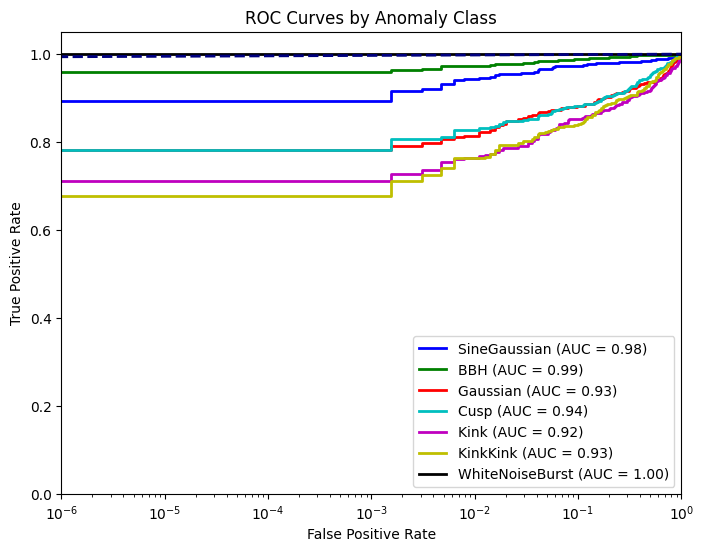

In [30]:
plt.figure(figsize=(8,6))
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']  # Colors for each anomaly class

for i, anomaly_class in enumerate(signal_classes[:-1]):  # Exclude "Background"
    # The anomaly class numeric label is i+1.
    anomaly_val = i + 1
    # Filter to only examples that are either the current anomaly class or Background (label 8).
    idx = np.where((all_labels == anomaly_val) | (all_labels == 8))[0]
    if idx.size == 0:
        continue  # skip if no examples
    scores_i = all_scores[idx]
    # Create binary ground truth: positive if the example is of the current anomaly class, 0 if background.
    binary_labels = (all_labels[idx] == anomaly_val).astype(int)
    
    # Compute the ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(binary_labels, scores_i)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, color=colors[i % len(colors)], lw=2,
             label=f"{anomaly_class} (AUC = {roc_auc:.2f})")

# Plot reference line (diagonal)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([1e-6, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#make x axis log
plt.xscale('log')

plt.title("ROC Curves by Anomaly Class")
plt.legend(loc="lower right")
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

0
1
2
3
4
5
6
7


  0%|          | 0/10 [01:23<?, ?it/s]


Threshold for 1/year FAR = -0.1981


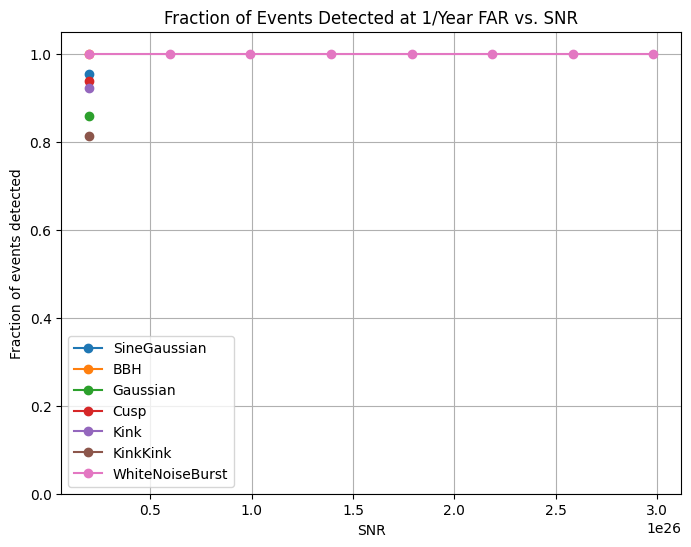

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import roc_curve

# -----------------------------------------------------------------------------
# 1) EVALUATE THE COMBINED MODEL TO GATHER SCORES, LABELS, AND SNRS
# -----------------------------------------------------------------------------

combined_model_path = combined_model_path = "/home/eric.moreno/gwak2/gwak/output/combination/model_JIT.pt" # Replace with your actual model file path
combined_model = torch.jit.load(combined_model_path)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
combined_model = combined_model.to(device)
combined_model.eval()

all_scores = []
all_labels = []
all_snrs = []

# Loop over test loader
for batch in tqdm(test_loader):
    [batch] = batch
    waveforms, params, ras, decs, phics = loader.generate_waveforms(batch.shape[0])
    batch = batch.to(device)

    # multiInject now returns (injected_batch, snrs)
    injected, snrs = loader.multiInject_SNRs(waveforms, batch)

    # Build the ground-truth labels (1..7 for anomaly classes, 8 for background)
    labels = torch.cat(
        [(i + 1) * torch.ones(loader.num_per_class[i]) for i in range(loader.num_classes)]
    ).to(device)

    with torch.no_grad():
        # Evaluate combined model to get anomaly scores
        scores = combined_model(injected).squeeze()
        scores = scores.cpu().numpy()

    # Invert so that higher = more anomalous
    scores = -scores

    all_scores.append(scores)
    all_labels.append(labels.cpu().numpy())
    all_snrs.append(snrs.cpu().numpy())

    break 

# Concatenate across all batches
all_scores = np.concatenate(all_scores)
all_labels = np.concatenate(all_labels)
all_snrs = np.concatenate(all_snrs)

# -----------------------------------------------------------------------------
# 2) DETERMINE THE THRESHOLD THAT YIELDS 1/YEAR FALSE ALARM RATE
# -----------------------------------------------------------------------------

segment_duration = 0.5
year_sec = 3.154e7

fraction_1yr = (1.0 / year_sec) * segment_duration

# Extract background-only data
bg_mask = (all_labels == 8)
bg_scores = all_scores[bg_mask]
N_bg = len(bg_scores)
if N_bg == 0:
    raise ValueError("No background samples found in the test set!")

# Sort background scores descending (largest first)
bg_scores_sorted = np.sort(bg_scores)[::-1]

# The index in this sorted array that corresponds to fraction_1yr
target_index = fraction_1yr * N_bg
i_threshold = int(np.round(target_index))

# Clamp to valid range
i_threshold = max(i_threshold, 0)
i_threshold = min(i_threshold, N_bg - 1)

threshold_1yr = bg_scores_sorted[i_threshold]
threshold_1yr = -0.1981
print(f"Threshold for 1/year FAR = {threshold_1yr:.4f}")

# -----------------------------------------------------------------------------
# 3) BIN ANOMALIES BY SNR AND COMPUTE FRACTION DETECTED (SCORE > threshold_1yr)
# -----------------------------------------------------------------------------

# Your class names, last is "Background"
signal_classes = [
    "SineGaussian",
    "BBH",
    "Gaussian",
    "Cusp",
    "Kink",
    "KinkKink",
    "WhiteNoiseBurst",
    "Background",
]

# We'll define 10 bins in SNR from the minimum anomaly SNR to the maximum
# anomaly SNR across all anomaly classes (labels 1..7).
anom_mask = (all_labels != 8)
if np.any(anom_mask):
    snr_min, snr_max = all_snrs[anom_mask].min(), all_snrs[anom_mask].max()
else:
    raise ValueError("No anomaly samples found in the test set!")

num_bins = 10
bin_edges = np.linspace(snr_min, snr_max, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

plt.figure(figsize=(8,6))

for i, anom_class_name in enumerate(signal_classes[:-1]):
    class_label = i + 1  # classes are 1..7
    mask = (all_labels == class_label)
    if not np.any(mask):
        # If no samples for that class, skip
        continue

    class_scores = all_scores[mask]
    class_snrs = all_snrs[mask]

    # Bin by SNR
    bin_idx = np.digitize(class_snrs, bin_edges) - 1  # bin indices in [0..num_bins-1]

    frac_detected = []
    for b in range(num_bins):
        in_bin = (bin_idx == b)
        if not np.any(in_bin):
            frac_detected.append(np.nan)  # or 0.0 if you prefer
        else:
            # fraction that exceed threshold
            frac = np.mean(class_scores[in_bin] > threshold_1yr)
            frac_detected.append(frac)

    plt.plot(bin_centers, frac_detected, marker='o', label=anom_class_name)

plt.xlabel("SNR")
plt.ylabel("Fraction of events detected")
plt.title("Fraction of Events Detected at 1/Year FAR vs. SNR")
plt.ylim([0, 1.05])
plt.legend()
plt.grid(True)
plt.show()